# lab 7

# Supermodeling

## What is supermodeling

## Used Data Assimilation method

## Submodels

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [587]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import time
from math import ceil
from data_assimilation import assimilateLorenz
%matplotlib inline

In [588]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed


def plot_models(models, timelines=None, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()
    
    if timelines:
        plot_models_coords_in_time(models, timelines)
    
def plot_model(model, timeline=None, figsize=(5,5)):
    plot_models([model], figsize=figsize)
    if timeline is not None:
        plot_model_coords_in_time(model, timeline)

    
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def lorenz_step(coords, parameters, dt=0.01):
    rho, sigma, beta = parameters
    x, y, z = coords
    return coords + (np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z]) * dt)

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0, start_time=0.0, number_of_samples=4000, dt=0.01, plot=False):
    size = number_of_samples
    
    if start_time:
        size += ceil(start_time/dt)

    coords = np.empty([size,3])

    # Set initial values
    coords[0] = [x,y,z]
    parameters = [rho, sigma, beta]
    for i in range(size - 1):
        coords[i+1] = lorenz_step(coords[i],parameters, dt=dt)
    coords= coords[-number_of_samples:]
    if plot:
        plot_model(coords)
    return coords, np.arange(start_time, start_time+number_of_samples*dt, dt)

def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15,8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")
    
    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:,0], lw=0.5)
        py.plot(timeline, model[:,1], lw=0.5)
        pz.plot(timeline, model[:,2], lw=0.5, label=str(ix+1))

    pz.set_xlabel("Time index (x 100)")
    
    f.legend(title="Models in order")
    

def plot_model_coords_in_time(model, timeline):
    plot_models_coords_in_time([model], [timeline])

### Sandbox

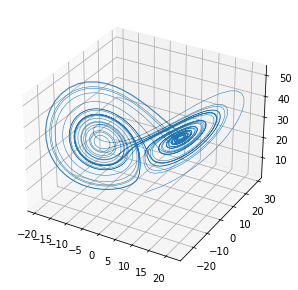

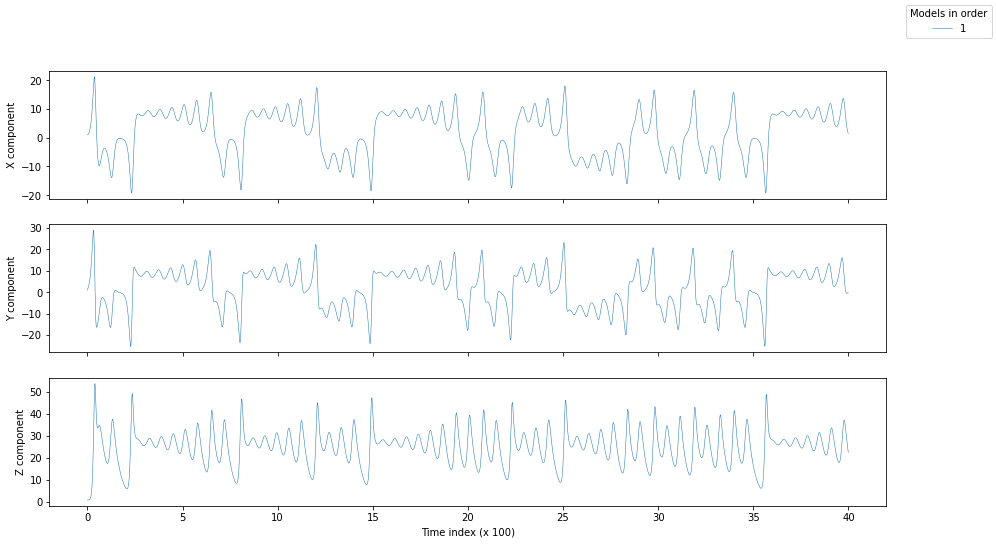

In [559]:
# generate and plot lorenz attractor
lorenz_attr, lorenz_timeline = generate_lorenz()
plot_model(lorenz_attr, lorenz_timeline)

In [513]:
model_coords = [np.array([1,1,1])]
model_coords.append([np.array(model_coords[-1]) + np.array(np.array(lorenz_step(model_coords[-1], [18.0, 7.0, 3.7])) * dt)])

In [378]:
model_1_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 13.25,
    rho = 19.0,
    beta = 3.5
)

model_2_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 7.0,
    rho = 18.0,
    beta = 3.7
)


model_3_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 6.5,
    rho = 38.0,
    beta = 1.7
)

models_start = 15
number_of_samples = 200

m1, t1 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples,**model_1_params)
m2, t2 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples, **model_2_params)
m3, t3 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples, **model_3_params)

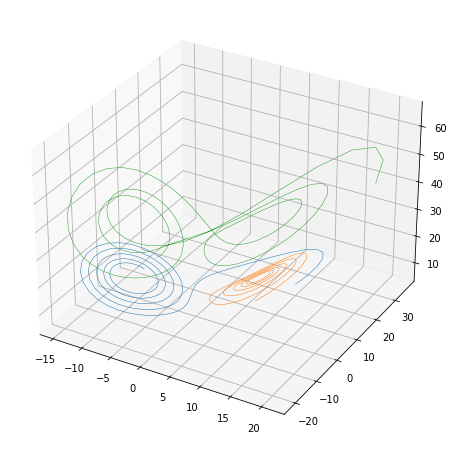

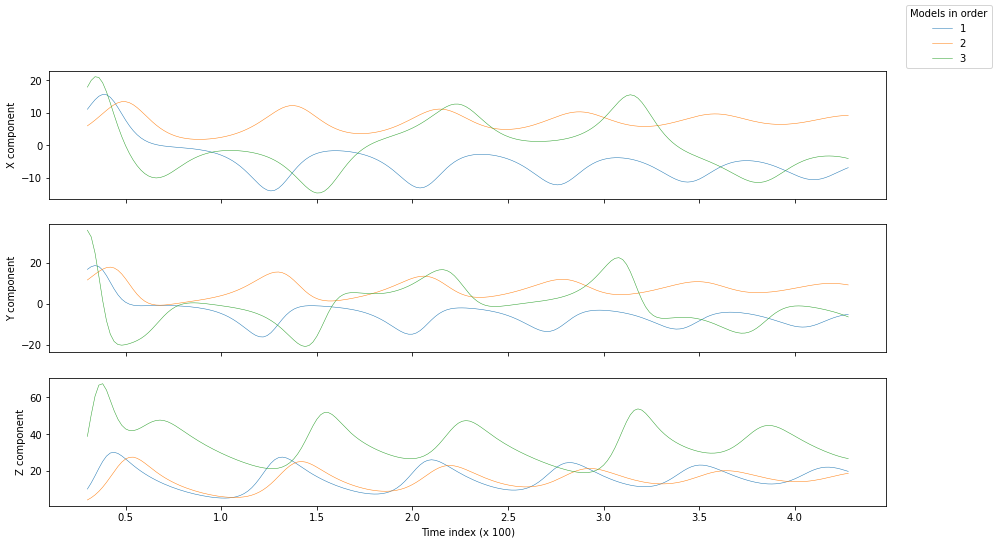

In [385]:
plot_models([m1,m2,m3])
plot_models_coords_in_time([m1,m2,m3], [t1,t2,t3])

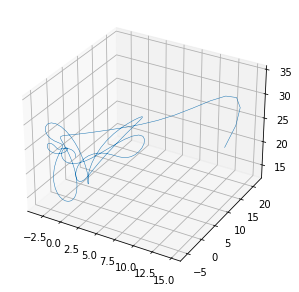

In [382]:
mean_model = calc_mean_lorenz(np.array([m1, m2, m3]))
plot_model(mean_model)

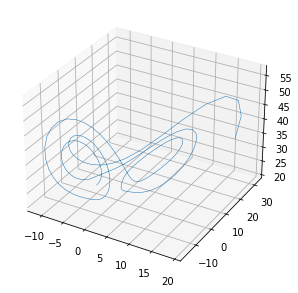

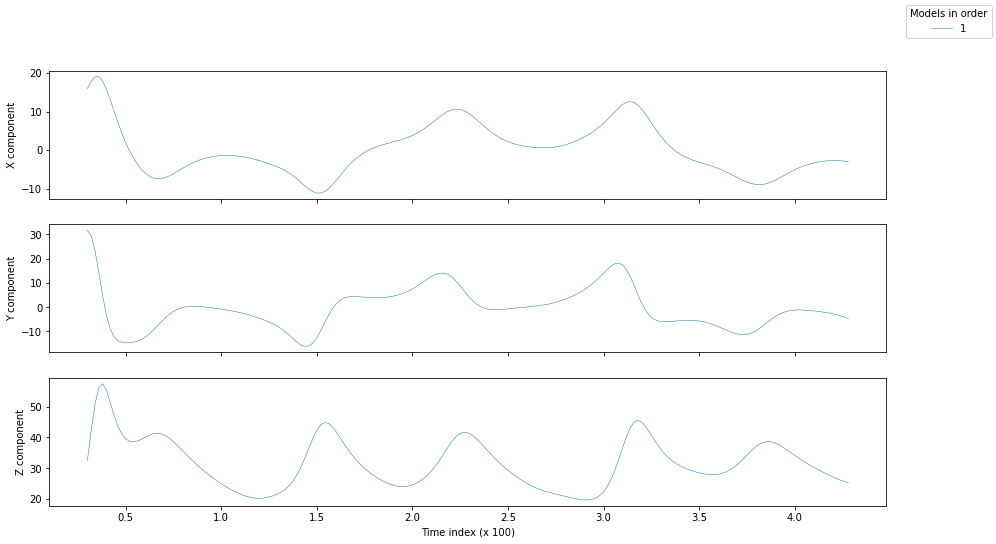

In [386]:
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    [0.1,0.1,0.8]
)

plot_model(weighted_avg_model)
plot_model_coords_in_time(weighted_avg_model, t1)

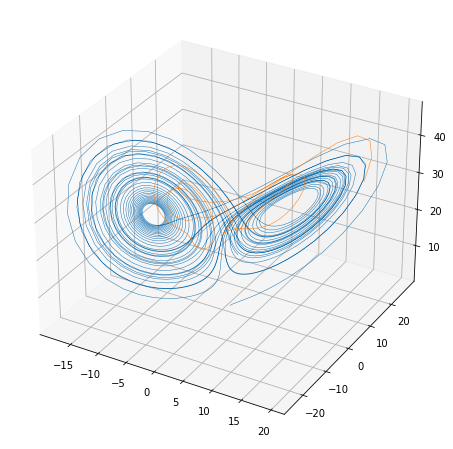

In [389]:
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    [1,1,3]
)

plot_models([lorenz_attr,weighted_avg_model])

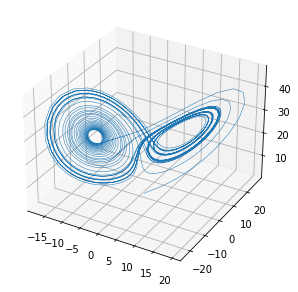

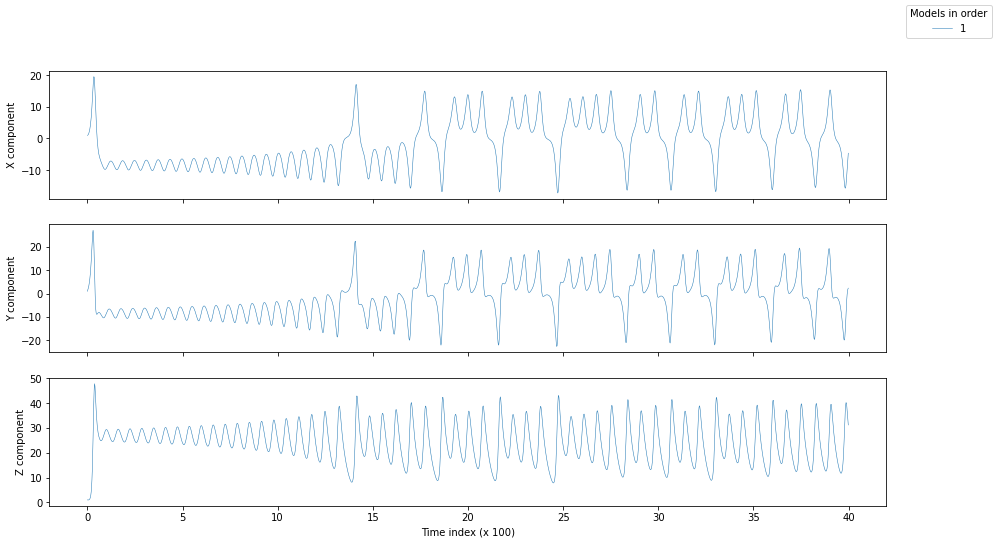

In [464]:
lorenz, lorenz_timeline = generate_lorenz()
plot_model(lorenz)
plot_model_coords_in_time(lorenz, lorenz_timeline)

## Task 1 - choose a fragment of lorenz 63 attractor

In [582]:
models_start = 800
number_of_samples = 400

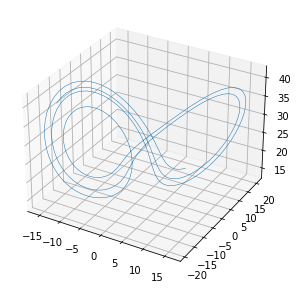

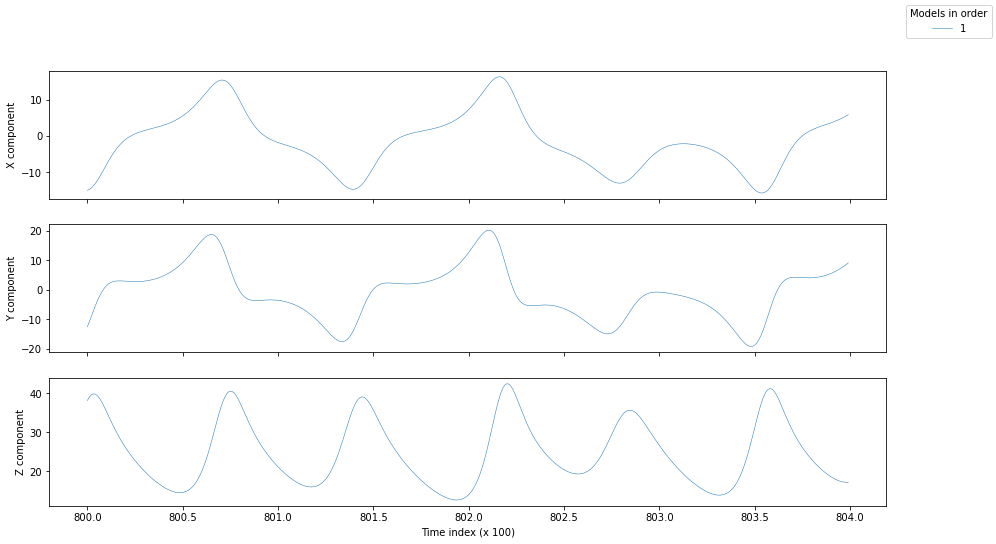

In [583]:
l63, l63_timeline = generate_lorenz(
    start_time=models_start, 
    number_of_samples=number_of_samples
)
plot_model(l63)
plot_model_coords_in_time(l63, l63_timeline)

## Task 2 - have fun with 4dvar

In [624]:
def lorenz_research(
    start_time = 4.5,
    number_of_samples = 200,
    steps_4dvar = 20,
    small_plot = True,
    full_plot = True,
    initial_params = None
):
    l63_gt, l63_timeline_gt = generate_lorenz(
        start_time=start_time, 
        number_of_samples=number_of_samples
    )


    initial = dict(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma = 10.0,
        rho = 20.,
        beta = 5.
    )
    
    if initial_params is not None:
        initial.update(initial_params)

    error_vector = [0.1, 0.1, 0.1, 100, 100, 100]

    coords_and_params = assimilateLorenz(
        initial, 
        l63_gt,
        lorenz_step, 
        maximum_number_of_steps=steps_4dvar,
        verbose=True, 
        error_vector=error_vector
    )
    l63_4dv, l63_4dv_timeline = generate_lorenz(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=coords_and_params['sigma'],
        rho=coords_and_params['rho'],
        beta=coords_and_params['beta'],
        number_of_samples=number_of_samples
    )

    if small_plot:
        plot_models(
            [l63_gt, l63_4dv],
            [l63_timeline_gt, l63_timeline_gt]
        )

    full_lorenz, fl_timeline = generate_lorenz()
    full_predicted, full_pred_timeline = generate_lorenz(sigma=coords_and_params['sigma'],rho=coords_and_params['rho'],beta=coords_and_params['beta'])
        
    if full_plot:
        plot_models([full_lorenz, full_predicted], [fl_timeline, full_pred_timeline])
        
    return {
        'partial': {
            'gt': [l63_gt, l63_timeline_gt],
            'pred': [l63_4dv, l63_4dv_timeline],
        },
        'full': {
            'gt': [full_lorenz, fl_timeline],
            'pred': [full_predicted, full_pred_timeline],
        }
    }

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 20.         10.          5.        ]
  Intermediate CurrentState at the current iteration: [ 9.8590768   8.81394214 30.53124088 20.80070144  9.93460107  5.22059616]
  Intermediate CurrentState at the current iteration: [ 9.69381594  9.04372603 30.32054186 21.25287458  9.84350509  4.8635347 ]
  Intermediate CurrentState at the current iteration: [ 9.03277249  9.96286159 29.47774578 23.06156714  9.47912119  3.43528883]
  Intermediate CurrentState at the current iteration: [ 8.36999346 10.70405437 28.61992747 24.9854204   9.17555336  2.6384734 ]
  Intermediate CurrentState at the current iteration: [ 8.6965648  10.3388462  29.04260058 24.03747953  9.32513044  3.03108854]
  Intermediate CurrentState at the current iteration: [ 8.34102649 10.55153436 28.60863309 25.13525763  9.17971464  3.1407857 ]
  Intermediate CurrentState at the current iteration: [ 8.28418204 10.58842048 28.5480776  25.38319312  

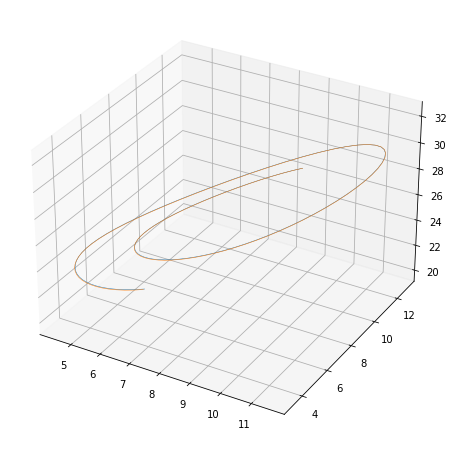

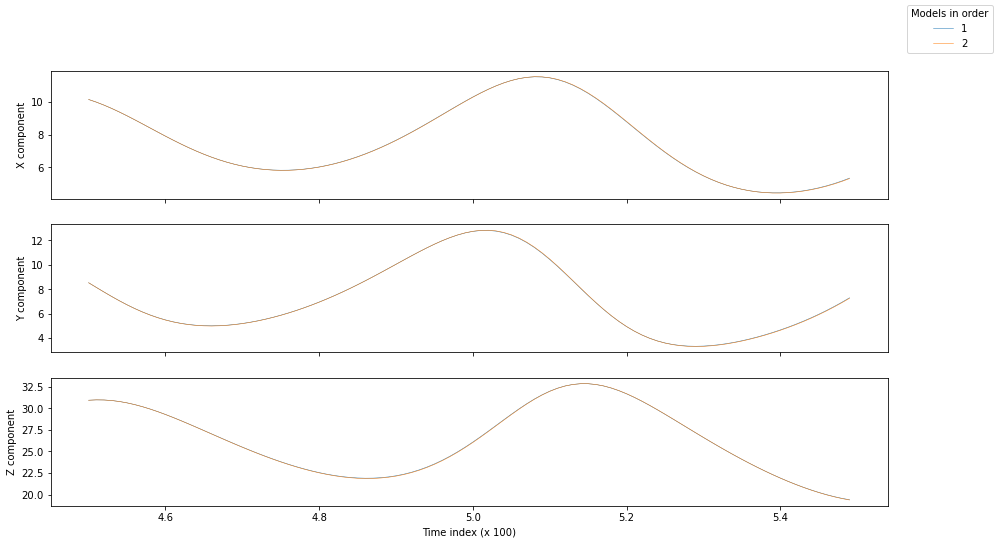

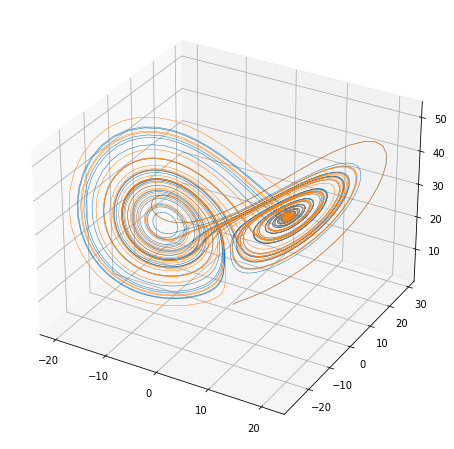

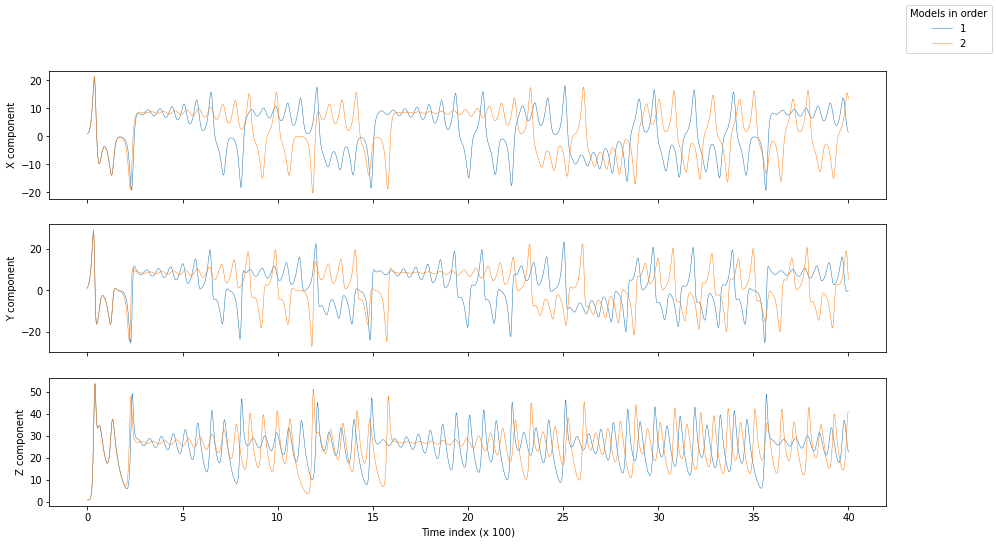

In [618]:
lorenz_try = lorenz_research(
    number_of_samples=100
)

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 20.         10.          5.        ]
  Intermediate CurrentState at the current iteration: [ 9.86628797  8.82426338 30.55010556 20.75255581  9.97484135  5.37338893]
  Intermediate CurrentState at the current iteration: [ 9.4830895   9.46380747 30.00791893 21.98747598  9.92703012  5.16053341]
  Intermediate CurrentState at the current iteration: [ 8.60326728 11.10315037 28.75030428 24.75390352  9.75934073  3.65305966]
  Intermediate CurrentState at the current iteration: [ 8.37418776 11.27121677 28.51072243 26.27330692  9.76466568  2.80808566]
  Intermediate CurrentState at the current iteration: [ 8.49382418 11.18344436 28.63584368 25.47980088  9.76188474  3.249372  ]
  Intermediate CurrentState at the current iteration: [ 8.48689375 11.06298725 28.68724545 25.83782003  9.77481202  3.15157106]
  Intermediate CurrentState at the current iteration: [ 8.6048922  10.54701863 29.11124827 26.55069921  

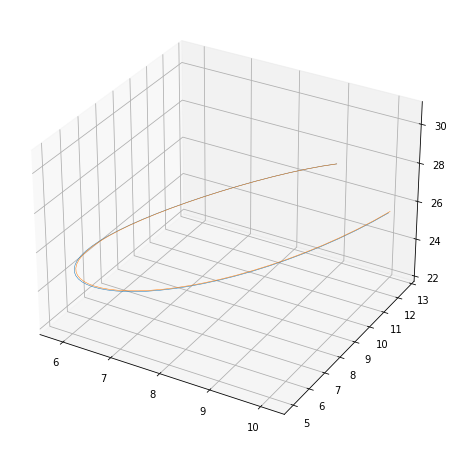

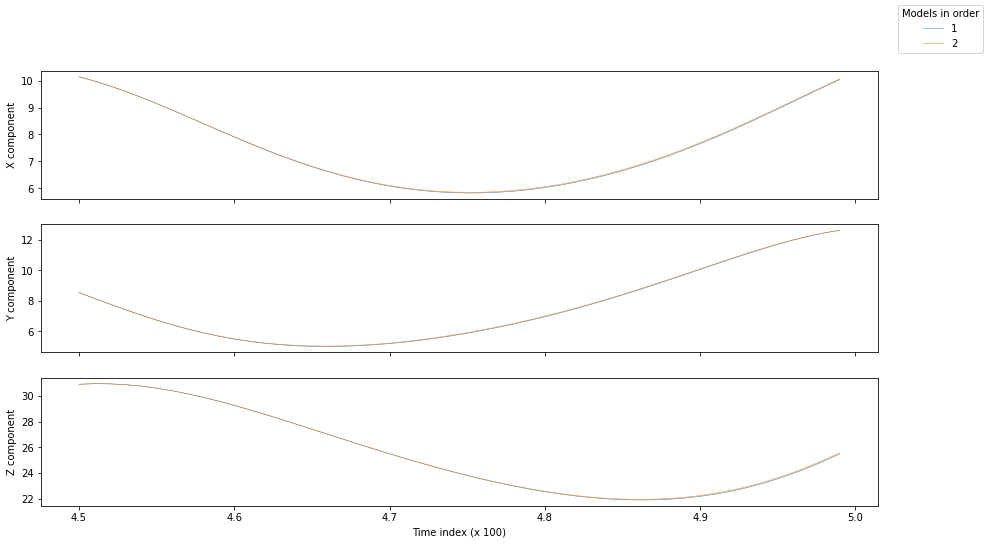

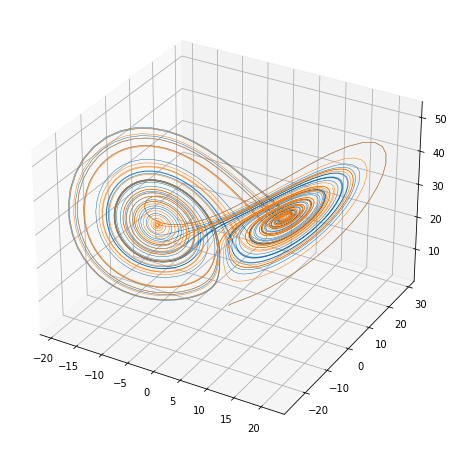

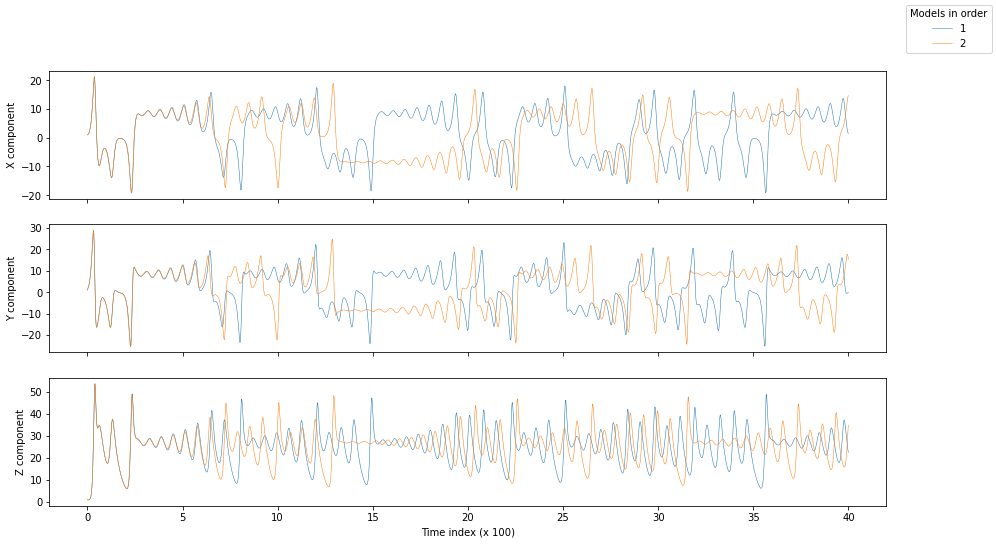

In [611]:
lorenz_research(
    number_of_samples=50
)

## Task 3 - play with iterations

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 20.         10.          5.        ]
  Intermediate CurrentState at the current iteration: [ 9.86628797  8.82426338 30.55010556 20.75255581  9.97484135  5.37338893]
  Intermediate CurrentState at the current iteration: [ 9.4830895   9.46380747 30.00791893 21.98747598  9.92703012  5.16053341]
  Intermediate CurrentState at the current iteration: [ 8.60326728 11.10315037 28.75030428 24.75390352  9.75934073  3.65305966]
  Intermediate CurrentState at the current iteration: [ 8.37418776 11.27121677 28.51072243 26.27330692  9.76466568  2.80808566]
  Intermediate CurrentState at the current iteration: [ 8.49382418 11.18344436 28.63584368 25.47980088  9.76188474  3.249372  ]
  Intermediate CurrentState at the current iteration: [ 8.48689375 11.06298725 28.68724545 25.83782003  9.77481202  3.15157106]
  Intermediate CurrentState at the current iteration: [ 8.6048922  10.54701863 29.11124827 26.55069921  

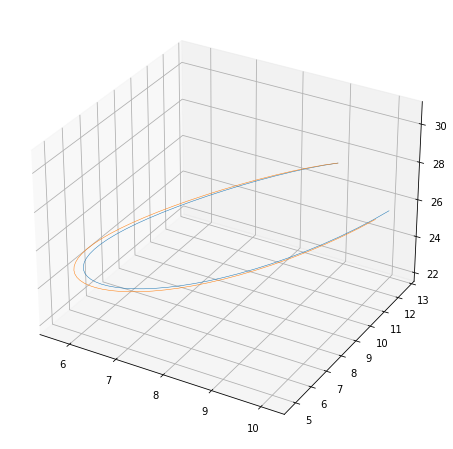

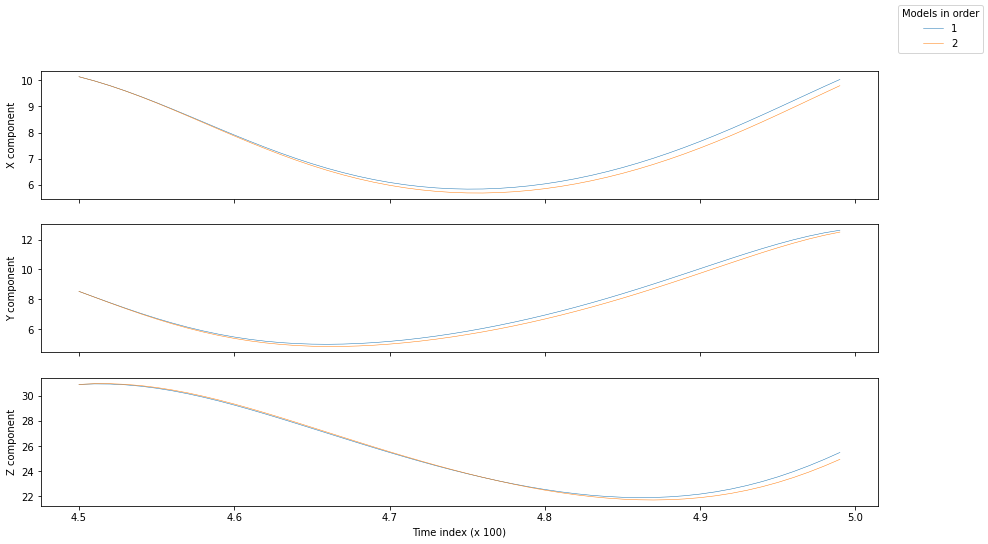

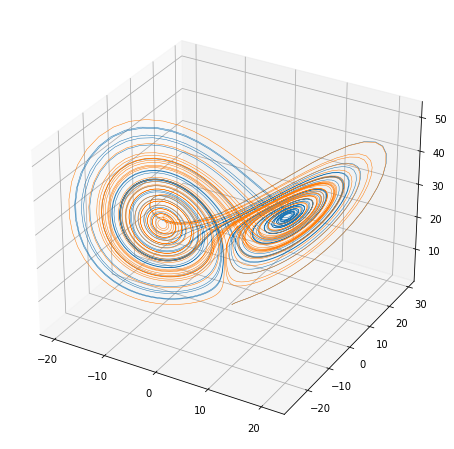

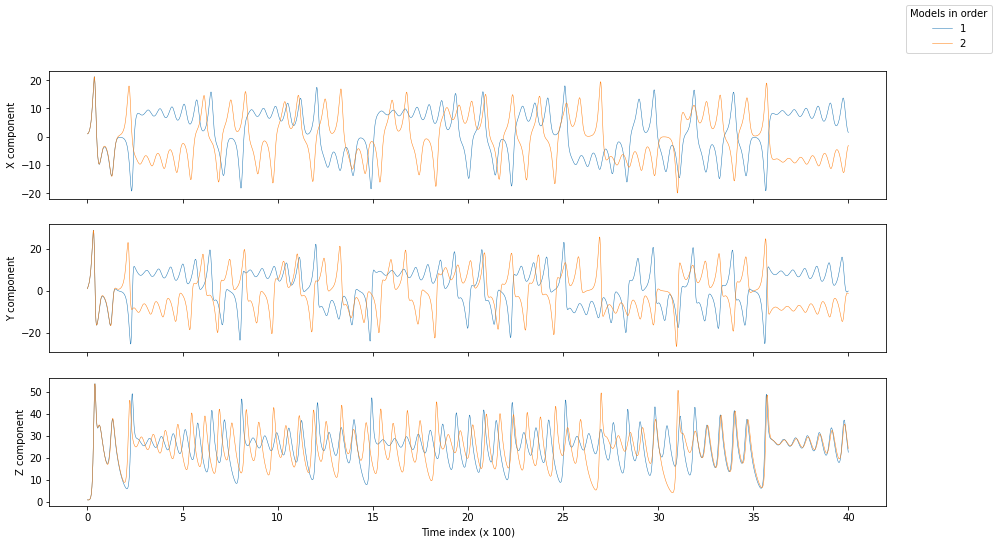

In [612]:
lorenz_research(
    number_of_samples=50,
    steps_4dvar = 10
)

## Task 4 - create submodels

In [619]:
def set_submodel_consts(
    number_of_samples = 200,
    steps_4dvar = 20
):    
    def create_submodel(sigma, rho, beta, start_time = 4.5):
            
        return lorenz_research(    
            start_time = start_time,
            number_of_samples = number_of_samples,
            steps_4dvar = steps_4dvar,
            small_plot = True,
            full_plot = False,
            initial_params = dict(sigma=sigma,rho=rho,beta=beta)
        )
        
#         l63_gt, l63_timeline_gt = generate_lorenz(
#             start_time=start_time, 
#             number_of_samples=number_of_samples
#         )
    
#         initial = dict(
#             x=l63_gt[0][0], 
#             y=l63_gt[0][1],
#             z=l63_gt[0][2],
#             sigma=sigma,
#             rho=rho,
#             beta=beta
#         )

#         error_vector = [0.1, 0.1, 0.1, 100, 100, 100]
#         coords_and_params = assimilateLorenz(
#             initial, 
#             l63_gt,
#             lorenz_step, 
#             maximum_number_of_steps=steps_4dvar,
#             verbose=True, 
#             error_vector=error_vector
#         )
        
#         return dict(sigma=coords_and_params['sigma'],rho=coords_and_params['rho'],beta=coords_and_params['beta'])
    return create_submodel

In [622]:
submodel_creator = set_submodel_consts(
    number_of_samples = 50,
    steps_4dvar = 20
)

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 20.         10.          5.        ]
  Intermediate CurrentState at the current iteration: [ 9.86628797  8.82426338 30.55010556 20.75255581  9.97484135  5.37338893]
  Intermediate CurrentState at the current iteration: [ 9.4830895   9.46380747 30.00791893 21.98747598  9.92703012  5.16053341]
  Intermediate CurrentState at the current iteration: [ 8.60326728 11.10315037 28.75030428 24.75390352  9.75934073  3.65305966]
  Intermediate CurrentState at the current iteration: [ 8.37418776 11.27121677 28.51072243 26.27330692  9.76466568  2.80808566]
  Intermediate CurrentState at the current iteration: [ 8.49382418 11.18344436 28.63584368 25.47980088  9.76188474  3.249372  ]
  Intermediate CurrentState at the current iteration: [ 8.48689375 11.06298725 28.68724545 25.83782003  9.77481202  3.15157106]
  Intermediate CurrentState at the current iteration: [ 8.6048922  10.54701863 29.11124827 26.55069921  

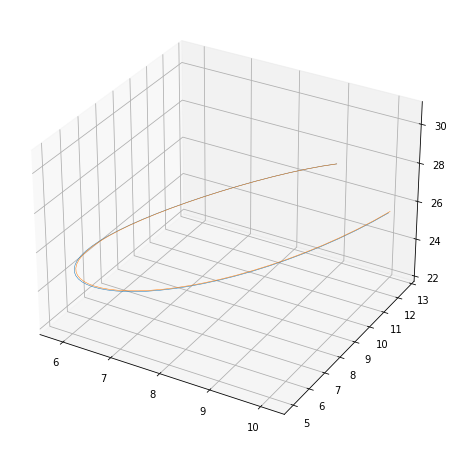

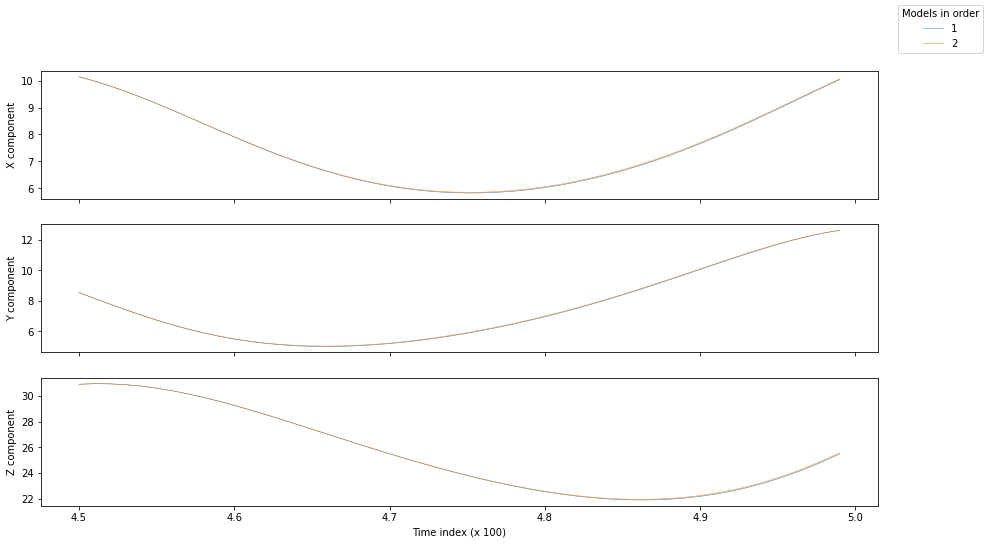

In [625]:
sm1 = submodel_creator(
    sigma = 10.0,
    rho = 20.,
    beta = 5.,
    start_time = 4.5
)

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 23.          6.          5.4       ]
  Intermediate CurrentState at the current iteration: [10.11252806  8.87567458 30.78296057 23.25914523  5.9039813   4.5117102 ]
  Intermediate CurrentState at the current iteration: [ 9.75437175 10.07600086 29.95163241 25.1608971   5.59349142  2.30027025]
  Intermediate CurrentState at the current iteration: [ 9.94223359  9.44640004 30.38768459 24.1633812   5.75635104  3.4602252 ]
  Intermediate CurrentState at the current iteration: [ 9.61668533 10.04654243 29.75931725 25.55364934  5.54192712  2.89265369]
  Intermediate CurrentState at the current iteration: [ 9.38823097 10.19691738 29.48420158 26.28917567  5.38930736  3.22063128]
  Intermediate CurrentState at the current iteration: [ 9.36268029 10.23521389 29.44981513 26.43499972  5.37787938  3.11458946]
  Intermediate CurrentState at the current iteration: [ 9.36122948 10.20155933 29.48539496 26.4808116   

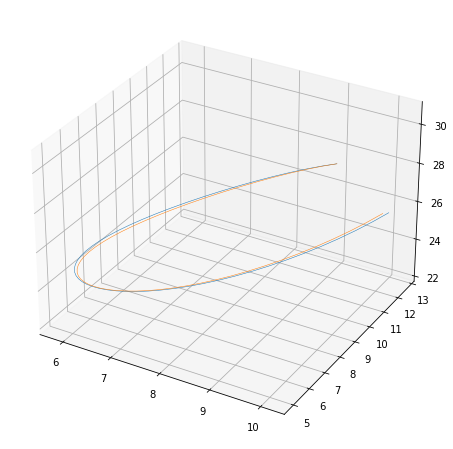

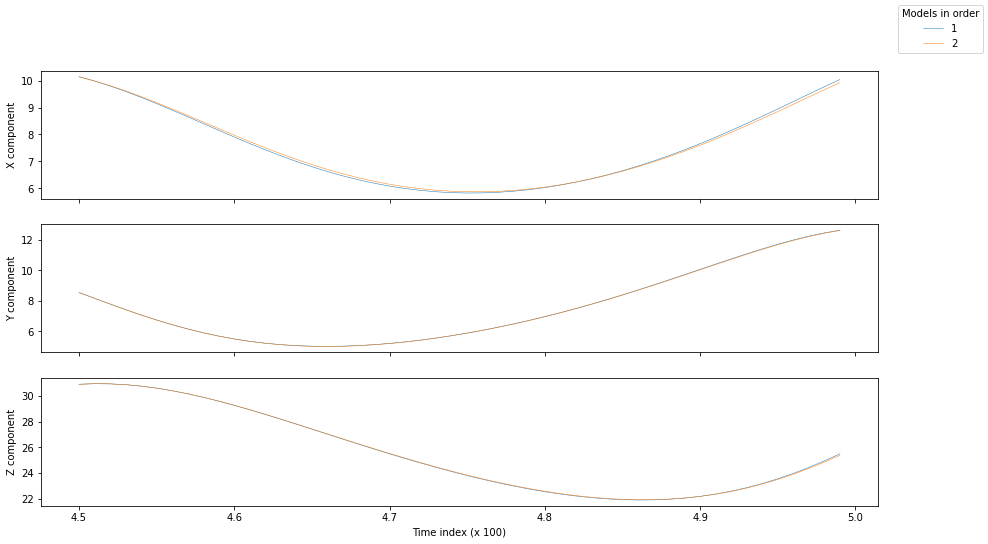

In [641]:
sm2 = submodel_creator(
    sigma = 6.0,
    rho = 23.0,
    beta = 5.4,
    start_time = 4.5
)

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 30.          2.         10.4       ]
  Intermediate CurrentState at the current iteration: [10.49052344  8.67053616 30.95249597 29.52645746  2.12440543  9.61307224]
  Intermediate CurrentState at the current iteration: [11.88396606  9.21223247 31.09840671 27.6322873   2.62202713  6.46536118]
  Intermediate CurrentState at the current iteration: [ 1.39654600e+01  1.23048768e+01  3.12306226e+01  2.27983037e+01
  2.53978814e-02 -9.14690964e+00]
  Intermediate CurrentState at the current iteration: [12.70388573 10.43045365 31.15048776 25.72813649  1.59919088  0.31554348]
  Intermediate CurrentState at the current iteration: [12.23883191  9.73948546 31.12094768 26.8081601   2.17933784  3.80368544]
  Intermediate CurrentState at the current iteration: [11.86304425  9.9314464  31.05790954 26.77387096  2.57754384  2.25792333]
  Intermediate CurrentState at the current iteration: [12.10675662  9.80695254 

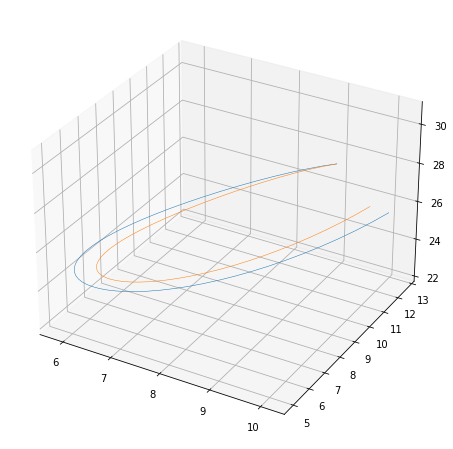

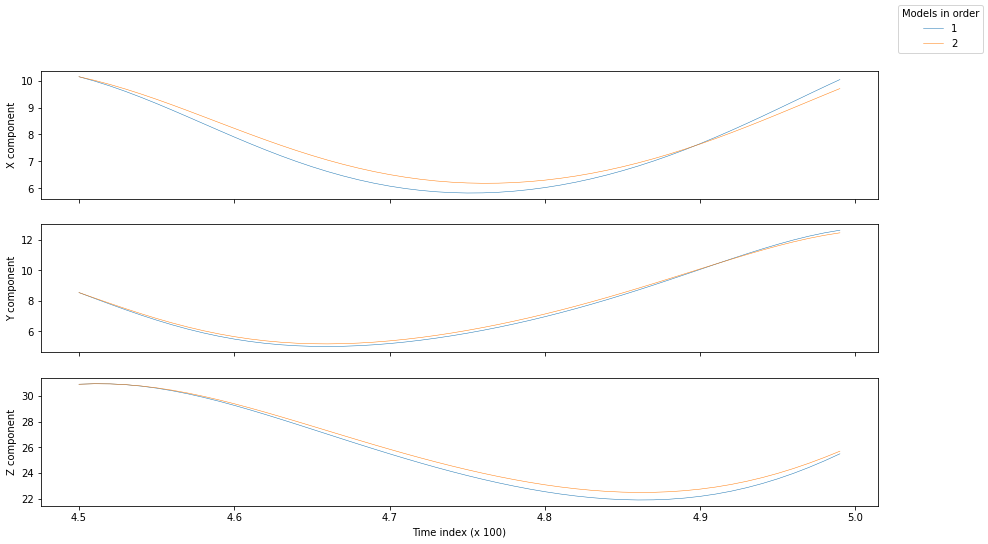

In [657]:
sm3 = submodel_creator(
    sigma = 2.0,
    rho = 30.0,
    beta = 10.4,
    start_time = 4.5
)

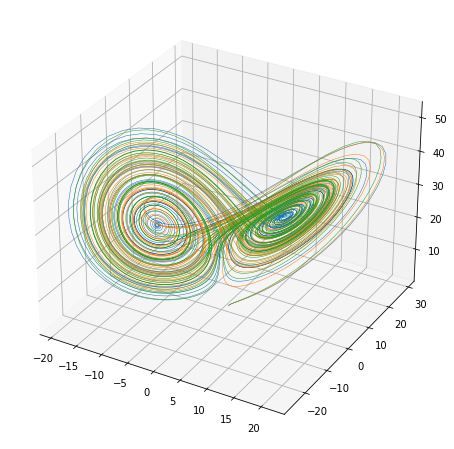

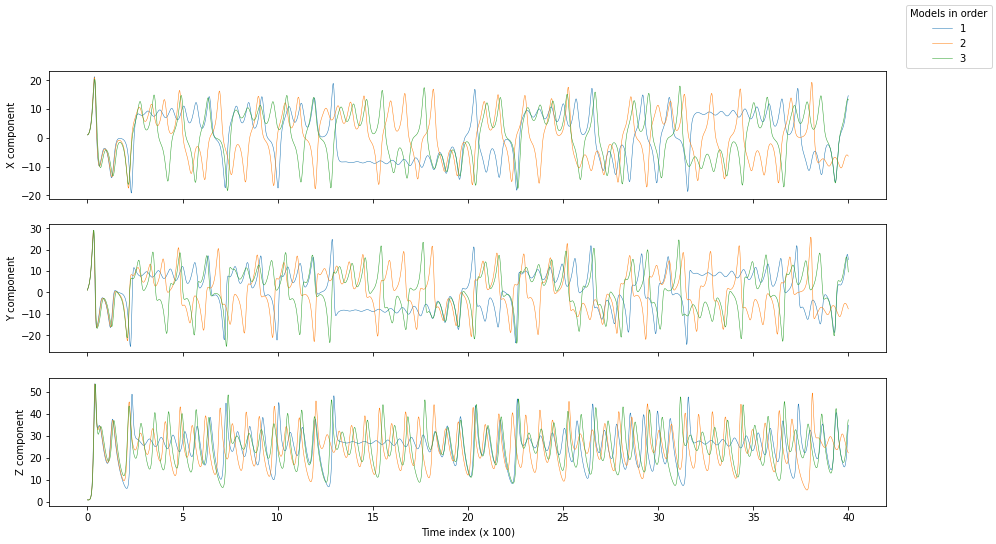

In [658]:
plot_models([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
],
[
    sm1['full']['pred'][1],
    sm2['full']['pred'][1],
    sm3['full']['pred'][1],
]
)

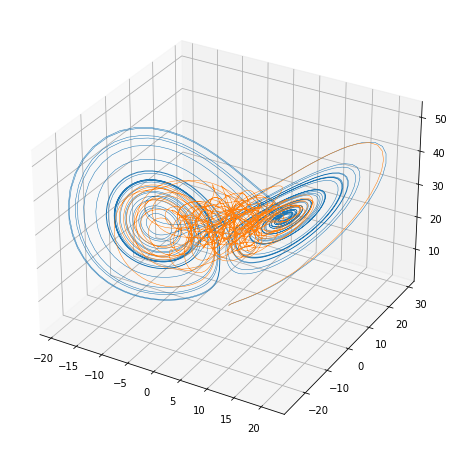

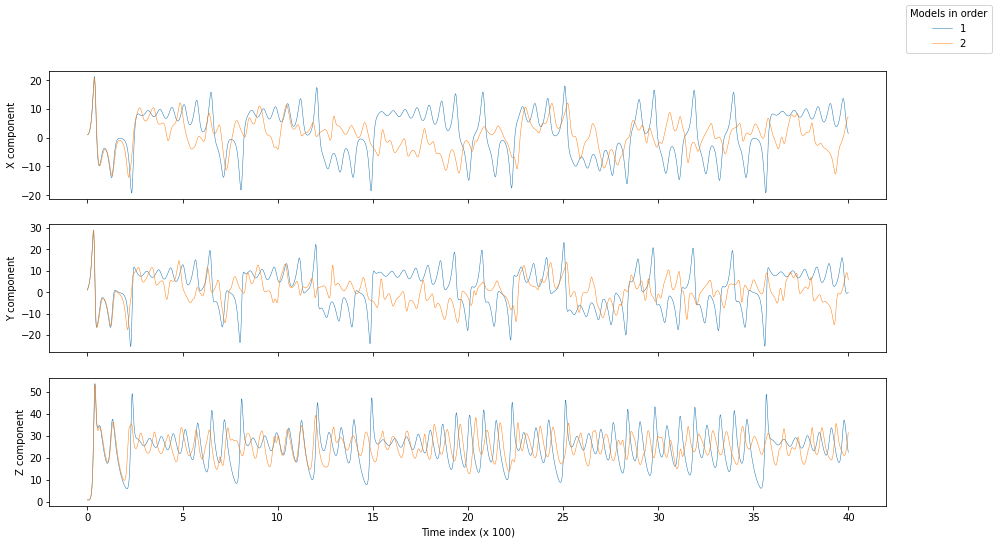

In [659]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 5 - mean average from submodels

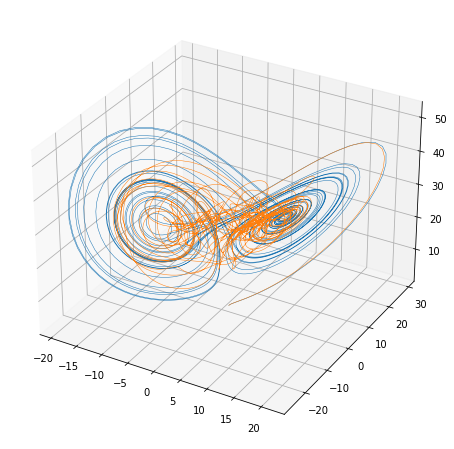

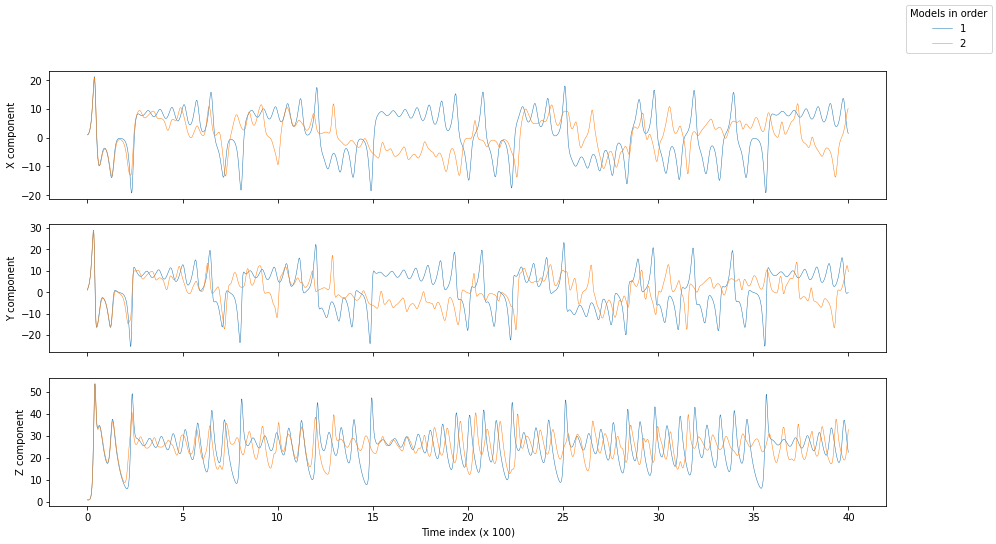

In [667]:
weights = [3,1,1]
mean_submodel = calc_weighted_average_lorenz(np.array([
        sm1['full']['pred'][0],
        sm2['full']['pred'][0],
        sm3['full']['pred'][0],
    ]),
    weights
)

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])